In [31]:
from PyQt5.QtWidgets import *
from PyQt5.QtGui import *
from PyQt5.QtCore import Qt


In [32]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cmath
import math
from commpy.filters import rcosfilter
from ipywidgets import interact, widgets
import dsp_lib

In [33]:
from scipy.signal import butter, filtfilt
import os
from array import array



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[[45721.305]
 [55742.773]
 [64428.27 ]
 [71160.734]
 [75564.46 ]
 [77249.85 ]
 [75865.4  ]
 [71359.164]
 [63941.1  ]
 [53786.332]]
[29793.13671875-77538.1640625j  46261.5234375 -69438.2421875j
 58380.6640625 -59952.203125j   65365.33984375-49858.55859375j
 66933.8359375 -39735.796875j   63313.140625  -30195.25390625j
 55431.39453125-21806.9765625j  44699.70703125-14804.09277344j
 32539.69921875 -9161.34375j   ]


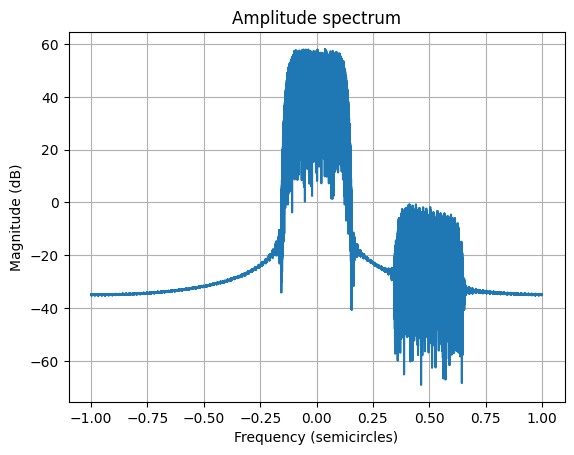

array([[-34.98668122],
       [-35.08166488],
       [-34.95289314],
       ...,
       [-35.01812745],
       [-35.10155497],
       [-34.91243319]])

In [34]:
%load_ext autoreload
%autoreload 2
import dsp_lib

# 1: Source signal
plt.close('all')
file_path = "/home/xy/cuda_filt_sig_int16.pcm"
file_path = "qpsk_rc_int16_1_sig.bin"
file_path = "/home/xy/projects/cuda/GPU_Overlap-and-save_convolution/GPU_OLS_C2C_sharedmemory/rrc_filtered.dat"
file_path = "qpsk_rrc_after_py_rrc_fl32.bin"

data_type = 'float32'
figure_counter = 0
source_samples = dsp_lib.read_signal(file_path, data_type, 0, 0, '')
source_signal = dsp_lib.make_cmplx_sig(source_samples)
print(source_signal[1031990:1031999])
dsp_lib.plot_spectrum(source_signal, 0)

In [35]:
def calc_var(signal):
    m = np.mean(signal)
    var = (np.square(np.abs(signal - m)))
    print(f"mean = {m}")
    print(var[:10])
    return np.sum((np.square(np.abs(signal - m))))

def calc_signal_rms(signal):
    quar1 = [num for num in signal if (num.real > 0) & (num.imag > 0)]
    quar2 = [num for num in signal if (num.real > 0) & (num.imag < 0)]
    quar3 = [num for num in signal if (num.real < 0) & (num.imag > 0)]
    quar4 = [num for num in signal if (num.real < 0) & (num.imag < 0)]
    
    print(quar1[:10])
    var1 = calc_var(quar1)
    var2 = calc_var(quar2)
    var3 = calc_var(quar3)
    var4 = calc_var(quar4)
    rms = np.sqrt((var1 + var2 + var3 + var4) / (len(quar1) + len(quar2) + len(quar3) + len(quar4)))
    print(f"rms = {rms}")


In [36]:
qpsk_samples = dsp_lib.read_signal('qpsk_constellation.dat', 'int16')
saved_qpsk = dsp_lib.make_cmplx_sig(qpsk_samples)
print(saved_qpsk[:10*8:8])

[[ 1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]]
[ 1.-1.j  1.+1.j -1.-1.j  1.-1.j  1.+1.j -1.+1.j -1.-1.j -1.-1.j  1.+1.j
 -1.-1.j]


In [37]:
def demodulate_qpsk(signal):
    symbols = np.empty(len(signal), dtype = np.csingle)
    for k in range(len(signal)):
        if (signal[k].real > 0) & (signal[k].imag > 0):
            symbols[k] =  1 + 1j
        elif (signal[k].real > 0) & (signal[k].imag < 0):
            symbols[k] =  1 - 1j
        elif (signal[k].real < 0) & (signal[k].imag > 0):
            symbols[k] = -1 + 1j
        elif (signal[k].real < 0) & (signal[k].imag < 0):
            symbols[k] = -1 - 1j
    print("Demodulated qpsk symbols")
    print(symbols[:10])
    return symbols

In [38]:
def plot_iq_pcm(delay: float, fsymb_to_fsampl: float, phase: float, f0: float):
    print(f"fract omega = {f0}, fsymb_to_fsampl = {fsymb_to_fsampl}, phase = {phase}")
    matplotlib.pyplot.close()
    signal_iq = source_signal[:(1032192 -1000)]
    mixed_sig = dsp_lib.add_freq(signal_iq, f0)
    sig_default = dsp_lib.add_phase(mixed_sig, phase)
    x0 = delay
    res_sig = dsp_lib.resampling_lagrange_step_ver(sig_default, fsymb_to_fsampl, x0)
    qpsk_symbs = demodulate_qpsk(res_sig)
    min_len = min(len(qpsk_symbs), len(saved_qpsk))
    print(len(qpsk_symbs))
    print(len(saved_qpsk))
    diff = qpsk_symbs[:min_len] - saved_qpsk[:min_len]
    max_diff = max(diff)
    print(f"max diff = {max_diff}, abs = {abs(max_diff)}")
    if abs(max_diff) < 0.001: 
        print(f"All QPSK symbols are right! max err = {max_diff}")
    else :
        print(f"Error in QPSK symbols, max_err = {max_diff}")
    calc_signal_rms(res_sig)
    plt.close()
    fig = plt.figure()
    ax = fig.add_subplot()
    #print(res_sig)
    plt.plot(res_sig.real, res_sig.imag, '.')
    plt.grid()
    ax.set_aspect('equal', adjustable='box')
    plt.show()

delay_float = widgets.BoundedFloatText(
    value=0,
    min=-1,
    max=1,
    step=0.001,
    description='Delay before first symbol, samples:',
    disabled=False
)

sps = widgets.BoundedFloatText(
    value=1.0,
    min=1,
    max=50,
    step=0.00001,
    description='SPS',
    disabled=False
)

phase_float = widgets.BoundedFloatText(
    value=.0,
    min=-1,
    max=1,
    step=0.0001,
    description='Phase, [-1, 1], semicircles',
    disabled=False
)

f0_float = widgets.BoundedFloatText(
    value=.0,
    min = -1,
    max = 1,
    step = 0.00001,
    description = 'f0, [0, 1], circles',
    disabled = False
)


interact(plot_iq_pcm, delay=delay_float, fsymb_to_fsampl=sps, phase = phase_float, f0 = f0_float)

interactive(children=(BoundedFloatText(value=0.0, description='Delay before first symbol, samples:', max=1.0, …

<function __main__.plot_iq_pcm(delay: float, fsymb_to_fsampl: float, phase: float, f0: float)>

In [39]:
224.67918395996094 # gpu fl32  225.2149200439453   223.12039184570312  225.49227905273438  225.05104064941406  225.05104064941406  227.8776092529297    225.23359968364701    
225.39353942871094 # py  fl32  225.21466064453125  223.12010192871094  225.49209594726562  225.05079650878906  226.0729522705078   227.87744140625      225.23337040808676
225.39353942871094 # py  fl64  225.21463012695312  223.12010192871094  225.4921112060547   225.05079650878906  226.07296752929688  227.87744140625      225.23337922638186

225.39353942871094

In [40]:
10 * math.log10(np.square(225.23359968364701) / np.square( 225.23337922638186)) # 224.0868377685547

8.501699634849938e-06